In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
#maybe not useful:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.svm import SVC

In [5]:
df = pd.read_csv('../data/final.csv')

In [7]:
df.drop(index=6, axis=0, inplace=True)

In [8]:
df.shape

(8935, 10)

In [9]:
target = df["target"]
features = df['doc']
features

0       .@wesley83 3 G iPhone 3 hrs tweet rise_austin ...
1       @jessedee know @fludapp Awesome iPad iPhone ap...
2                       @swonderlin wait iPad 2 sale SXSW
3       @sxsw hope year festival crashy year iPhone ap...
4       @sxtxstate great stuff Fri SXSW Marissa Mayer ...
                              ...                        
8931                                       Ipad SXSW link
8932    wave buzz rt @mention interrupt regularly sche...
8933    Google Zeiger physician report potential ae FD...
8934    Verizon iPhone customer complain time fall hou...
8935       RT @mention Google Tests check offer SXSW link
Name: doc, Length: 8935, dtype: object

In [10]:
target.shape

(8935,)

In [11]:
features.shape

(8935,)

### Train Test Split

In [12]:
x_full, x_test, y_full, y_test = train_test_split(features, target, test_size=.2, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_full, y_full, test_size=.2, random_state=10)

## Feature Engineering


In [13]:
tf = TfidfVectorizer()

In [14]:
tf_train = tf.fit_transform(x_train)
tf_val = tf.transform(x_val)
train_df = pd.DataFrame(tf_train.todense(), columns=tf.get_feature_names())
val_df = pd.DataFrame(tf_val.todense(), columns=tf.get_feature_names())

### Resampling

In [15]:
y_train.value_counts()

0    3436
2    1912
1     370
Name: target, dtype: int64

In [16]:
y_train = y_train.reset_index()["target"]

In [17]:
neutral_train_index = y_train[y_train==0]
negative_train_index = y_train[y_train==1]
positive_train_index = y_train[y_train==2]

In [20]:
neu_train = train_df.loc[neutral_train_index.index]
neu_train["TARGETXXXX"] = 0
neg_train = train_df.loc[negative_train_index.index]
neg_train["TARGETXXXX"] = 1
pos_train = train_df.loc[positive_train_index.index]
pos_train["TARGETXXXX"] = 2

neg_upsample = resample(neg_train,
                        replace = True,
                        n_samples = neu_train.shape[0] - neg_train.shape[0]
                       )
pos_upsample = resample(pos_train,
                        replace = True,
                        n_samples = neu_train.shape[0] - pos_train.shape[0]
                       )

display(neg_train.shape)
display(pos_train.shape)
display(neg_upsample.shape)
display(pos_upsample.shape)
display(neu_train.shape)

resampled_train = pd.concat([neu_train, neg_upsample, neg_train,
                             pos_upsample, pos_train
                             ],
                            ignore_index = True)

display(resampled_train.shape)

#x_train = resampled_train
resampled_y_train = resampled_train["TARGETXXXX"]
#y_train = y_train["target"]
resampled_train.drop(["TARGETXXXX"], axis = 1, inplace = True)

(370, 6695)

(1912, 6695)

(3066, 6695)

(1524, 6695)

(3436, 6695)

(10308, 6695)

In [21]:
resampled_y_train.value_counts()

2    3436
1    3436
0    3436
Name: TARGETXXXX, dtype: int64

In [23]:
resampled_train.shape, resampled_y_train.shape

((10308, 6694), (10308,))

In [24]:
from sklearn.dummy import DummyClassifier

In [25]:
dc = DummyClassifier()
dc.fit(X=resampled_train, y=resampled_y_train)
dcpred = dc.predict(val_df)
f1_score(dcpred, y_val, average='macro')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.3174153976287171

### Naive Bayes

In [50]:
gnb = GaussianNB()

In [55]:
gnb.fit(resampled_train, resampled_y_train)
gnb_pred = gnb.predict(val_df)

In [56]:
accuracy_score(gnb_pred, y_val)

0.4258741258741259

In [57]:
naive = confusion_matrix(y_val,gnb_pred)
naive

array([[318, 188, 363],
       [ 29,  32,  31],
       [126,  84, 259]])

Text(0.5, 1, 'Naive Bayes Resampled Confusion Matrix')

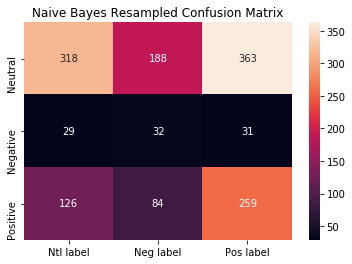

In [59]:
ax0 = plt.axes()
sns.heatmap(naive,
            annot=True,
            xticklabels = ["Ntl label", "Neg label", "Pos label"],
            yticklabels = ["Neutral", "Negative", "Positive"],
            fmt = 'g'
           )
ax0.set_title("Naive Bayes Resampled Confusion Matrix")

In [30]:
f1_score(y_pred, y_val, average='weighted')

0.401936643954703

### Multinomial Bayes

In [39]:
print("resampled search")
resampled_di = {}
for i in range(3,20):
    mnb = MultinomialNB(alpha=i/10)
    mnb.fit(resampled_train, resampled_y_train)
    y_pred = mnb.predict(val_df)
    resampled_di[i/10] = y_pred
    print(i/10, f1_score(y_pred, y_val, average='macro'), "f1macro")

resampled search
0.3 0.5050870640921772 f1macro
0.4 0.5066694700393981 f1macro
0.5 0.5091413060414464 f1macro
0.6 0.5129012909998584 f1macro
0.7 0.5181412047445917 f1macro
0.8 0.523318852996957 f1macro
0.9 0.5210440384148 f1macro
1.0 0.5235936814423288 f1macro
1.1 0.5221141687260116 f1macro
1.2 0.5216832869366542 f1macro
1.3 0.519675435945766 f1macro
1.4 0.5210828089241916 f1macro
1.5 0.5180038675361248 f1macro
1.6 0.5157911953470434 f1macro
1.7 0.5129846155972991 f1macro
1.8 0.5105025352782878 f1macro
1.9 0.508395525027836 f1macro


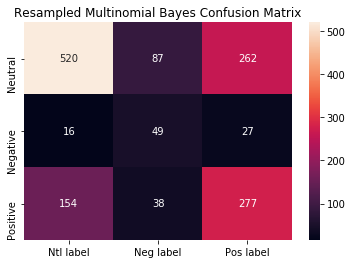

In [60]:
re_matrix = confusion_matrix(y_val, resampled_di[1])
ax1 = plt.axes()
sns.heatmap(re_matrix,
            annot=True,
            xticklabels = ["Ntl label", "Neg label", "Pos label"],
            yticklabels = ["Neutral", "Negative", "Positive"],
            fmt = 'g'
           )
ax1.set_title("Resampled Multinomial Bayes Confusion Matrix")
plt.savefig("../images/remulti.png")

In [61]:
print("unsampled search")
unsampled_di = {}
for i in range(1,15):
    mnb = MultinomialNB(alpha=i/10)
    mnb.fit(train_df, y_train)
    y_pred = mnb.predict(val_df)
    unsampled_di[i/10] = y_pred
    print(i/10, f1_score(y_pred, y_val, average='macro'), "f1macro")

unsampled search
0.1 0.5048471283625339 f1macro
0.2 0.4869539320777619 f1macro
0.3 0.4611552551168519 f1macro
0.4 0.44833852129725704 f1macro
0.5 0.4396150136090784 f1macro
0.6 0.4339446923762138 f1macro
0.7 0.4238859059366906 f1macro
0.8 0.4106045767826962 f1macro
0.9 0.39735452990416037 f1macro
1.0 0.390137492486416 f1macro
1.1 0.3854059503828368 f1macro
1.2 0.37367566280125636 f1macro
1.3 0.36851655156850155 f1macro
1.4 0.353166399016634 f1macro


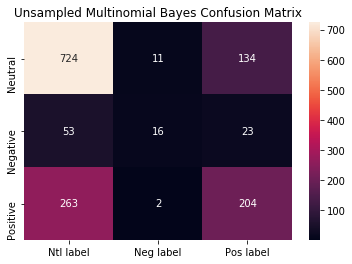

In [62]:
un_matrix = confusion_matrix(y_val, unsampled_di[.1])
ax2 = plt.axes()
sns.heatmap(un_matrix,
            annot=True,
            xticklabels = ["Ntl label", "Neg label", "Pos label"],
            yticklabels = ["Neutral", "Negative", "Positive"],
            fmt = 'g'
           )
ax2.set_title("Unsampled Multinomial Bayes Confusion Matrix")
plt.savefig("../images/unmulti.png")

In [68]:
y_val.values

array([0, 0, 2, ..., 0, 2, 0])

In [75]:
results = pd.DataFrame([y_val.values, resampled_di[1], x_val.reset_index()["doc"]]).T

In [77]:
results.loc[results[0]!=results[1]][2]

1       RT @mention SXSW crowd swarm iPad2 launch link...
5       bring lunch take train SXSW day earn iPad frug...
9                  wonder @mention come sxsw iPad 2 maybe
11      RT @mention Official SXSW App SXSW link androi...
12                     Apple SXSW store iPad 2 short line
                              ...                        
1406    quit fight sxsw ipad2 @mention Apple Store SXS...
1410    technology lightbox_photos want new Android Ca...
1419    SXSW Interactive Googles Mobile Future amp Elu...
1420        @mention @mention party doubt good party SXSW
1429                             download SXSW app Iphone
Name: 2, Length: 584, dtype: object